In this notebook I´m going to to plot the distribution of the different emotions.

# Libraries

In [724]:
# needed libraries
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.figure_factory as ff
import seaborn as sns 
import numpy as np
import datetime

# Functions

In [393]:
def remove_weekends(df):
    # insort week days
    day_names = pd.to_datetime(df["date"]).dt.day_name()
    df["days"] = day_names
    # remove Saturday
    df = df[df.days != 'Saturday']
    # remove Sunday
    df = df[df.days != 'Sunday']
    
    # just return the Date and Emotions
    df = df.loc[:,["date","emotion"]]
    df = df.reset_index(drop=True)
    return df

In [464]:
def index_change(df_emotion, df_finance):
    # compute the change value of open to close
    df_finance["Change"] = df_finance["Open"] - df_finance["Adj Close"]
    # init list to save the change values
    change_value_list = [] 
    
    for index in range(df_emotion.shape[0]):
        date = df_emotion["date"].iloc[index]
        # match the date of the df_emotion to the df_finace by its date & access the change for this day
        change = df_finance[df_finance.Date == str(date)]["Change"]
        # check if the date of emotion does exist in the finance data
        # not finance data on holidays, weekends, etc.
        if len(change) > 0:
            change_value = round(float(change),1)
            #round(float(data[data["Date"] == str(tweets_emotion_daily_noweekends["date"][0]) ]["Change"]),1)
        else:
            change_value = "nan"
        change_value_list.append(change_value)
    # add the change to emotion data frame
    df_emotion["Change"] = change_value_list
    df_emotion = df_emotion[df_emotion["Change"] != "nan"]
    df_emotion = df_emotion.reset_index(drop=True)
    
    return df_emotion

In [158]:
def daily_emotion(df):
    """
    This function creates the final result of the meotion majority vote.
    
    - Input:
    -- Transformed data frame, with the column weekday (output of the function "df_time_transformation")
    
    - Output:
    -- list: date as first value and corresponding emotion for that given day as second value
    
    """
    
    # init data frame, collect all tweets of that day
    daily_tweet = pd.DataFrame(columns = ["date","day", "retweets", "favorites", "text", "emotion", "emotion_probability"])
    # assign the first (last) tweet to the data frame
    daily_tweet = daily_tweet.append(df.iloc[0])

    # init list for emotion and dates which are going to be the output of the function
    emotion_list = []
    date_list = []

    # loop over each day
    for day in range(df.shape[0]-1):
        # init next day
        next_day = day + 1

        # add next row to data frame, if it´s the same day as the current
        if(df["day"][day] == df["day"][next_day]):
            daily_tweet = daily_tweet.append(df.iloc[next_day])
        else:

            #--------------- emotion voteing - Start
            # weighted method
            majority_value = daily_tweet.emotion_probability * daily_tweet.retweets/10000 * daily_tweet.favorites/10000
            #--------------- emotion voteing - End

            # assign as column of data frame
            daily_tweet["majority_value"] = majority_value

            # compute the emotion
            # save the emotion with its value into a dict
            emotion_oftheday = {}
            # access each emotion with it´s percentage
            for i in np.unique(daily_tweet.emotion):
                emotino = i
                percent = daily_tweet.loc[daily_tweet['emotion'] == i].majority_value.sum()
                emotion_oftheday[i] = round(percent,3)

            # get the main emotion of the day
            emotion = get_max_emotion(emotion_oftheday)[0]

            # assign results for the emotion & the date into the lists
            emotion_list.append(emotion)
            date_list.append(df["date"][day])

            # empty data frame & fill with the current day row
            daily_tweet = pd.DataFrame(columns = ["date","day", "retweets", "favorites", "text", "emotion", "emotion_probability"])
            daily_tweet = daily_tweet.append(df.iloc[day])

    # output
    df_new = pd.DataFrame(date_list, columns = ["Date"])
    df_new["Emotions"] = emotion_list
    
    return(df_new)
    

In [342]:
def df_time_transformation(df):
    """"
    This function does tranform the input df to a new df which can be used for following tasks
    
    Input:
    - df - input data frame with the columns: Unnamed: 0, index, usernamedate, retweets, favorites, text, emotion, emotion_probability
    
    Output:
    - data_time: data frame to return columns: date, day, retweets, favorites, text, emotion, emotion_probability
    
    """
    # drop not needed columns
    df = df.drop(columns = ["index", "username"])
    # transform the date format, need the same as in the finance data
    #df["date"] = pd.to_datetime(df["date"], format='%d.%m.%y %H:%M')
    # access just the date, don´t need the time
    df["date_wotime"] = df["date"].dt.date
    # access the day of each date
    day = [day.day_name() for day in  df["date"]]
    df["day"] = day
    #data_test
    df_new = df[["date_wotime","day", "emotion", "score"]]
    df_new = df_new.rename(columns={'date_wotime': 'date'})
    
    # the df to return
    return(df_new)

In [168]:
# function I created in Lable Test
def get_max_emotion(emotions_dict):
    
    # find max value and label
    max_probability = max(emotions_dict.values())  

    # getting all emotions containing the "max_probability" as string
    emotion_max_probability = [k for k, v in emotions_dict.items() if v == max_probability][0] 
    
    # return
    return(emotion_max_probability,max_probability)

In [379]:
def get_daily_max_emotion(dataframe):
    """
    The score is going to be used to check which of the emotion is the strongest of the day.
    
    Input: dataframe with date, day, emotion and score
    Output: dataframe date, day, emotion
    """
    daily_max_emotion = []
    day_name = []
    for day in np.unique(dataframe["date"]):
        df = data_new[dataframe["date"] == day]
        day_name.append(np.unique(df["day"])[0])
        # find max emotion of the day
        df2 = df.groupby("emotion").sum().reset_index()
        daily_emotion_index = df2[df2["score"] == max(df2["score"])]["emotion"].index[0]
        daily_emotion = df.iloc[daily_emotion_index]["emotion"]
        daily_max_emotion.append(daily_emotion)

    # return dataframe with days and emotion of the day
    daily_emotion_df = pd.DataFrame()
    daily_emotion_df["date"] = np.unique(data_new["date"])
    #daily_emotion_df["day"] = day_name
    daily_emotion_df["emotion"] = daily_max_emotion
    return(daily_emotion_df)

# Run it all function

In [727]:
def financial_analysis(twitter_data, finance_data, finance_data_name):
    
      
    print("Financial data analyis:", finance_data_name)
    ######### Finance data
    # for the analysis is "Date", "Open", "Close" what I need
    data = finance_data.loc[:,["Date","Open", "Adj Close"]]
    
    
    ######## Twitter data
    
    # pre-process twitter data
    tweets_emotion = twitter_data
    #emotion = emotion.loc[:,["date","emotion"]]
    # remove all NaN emotion
    ## via watson no classification possible
    tweets_emotion = tweets_emotion[tweets_emotion["emotion_probability"]< 1.0]
    # update date column wiht full year
    dates = []
    for date in tweets_emotion["date"]:
        day = date.split(".")[0]
        month = date.split(".")[1]
        date2 = "20" + date.split(".")[2]
        full_date = day+ "." + month + "." + date2
        # convert string to date type
        dates.append(datetime.datetime.strptime(full_date, '%d.%m.%Y %H:%M'))
    tweets_emotion["date"] = dates
    #--------------- emotion voteing - Start
    # weighted method
    tweets_emotion["score"] = round(tweets_emotion.emotion_probability * 
                                    tweets_emotion.retweets/10000 * 
                                    tweets_emotion.favorites/10000,2)
    #--------------- emotion voteing - End
    
    ########### Emotional vote ########## - Start
    tweets_emotion_trans = df_time_transformation(tweets_emotion)
    ########### Emotional vote ########## - End
    # get emotion of the day
    tweets_emotion_daily = get_daily_max_emotion(tweets_emotion_trans)
    
    
    # Combine finance and twitter data
    emotion_noweekend_change = index_change(tweets_emotion_daily, data)
    
    
    
    ############# Visualization - Start
    df = emotion_noweekend_change
    #### Boxplot
    fig = px.box(df, x="emotion", y="Change", color="emotion")
    #fig.savefig("boxplot_emotion_change.png")
    #fig.write_image(file='boxplot_emotion_change.png', format='.png')
    fig.show()
    #### Scatter plot
    fig = px.scatter(df, x = "date", y = "Change", color = "emotion")
    fig.show()
    #### Distributions - all emotions togeter
    # pre-processing
    df["date"] = pd.to_datetime(df["date"], format= "%Y-%m-%d")
    df["Change"] = df["Change"].astype('float64')
    
    sns.set(style="whitegrid")
    fig, ax = plt.subplots()

    for emo in pd.unique(df["emotion"]):
        sns.kdeplot(df[df["emotion"] == emo]["Change"], ax=ax, label = emo)
    plt.legend()
    plt.savefig(finance_data_name + "distribution_change_density.png")
    plt.show()
    
    

    
    #### Distributions - each emotion
    for emo in pd.unique(df["emotion"]):
        sns.distplot(df[df["emotion"] == emo]["Change"], kde = True, color ='red', bins = 50, label = emo)
        plt.legend()
        plt.savefig(finance_data_name + "densityplot_change_density_" + emo + ".png")
        plt.show()
        
    # print positive negative results
    emotions = np.unique(df["emotion"])
    for emo in emotions:
        print(emo, ":", percentage_positive_negative(df, emo))

# Load Twitter data

In [656]:
twitter_d = pd.read_csv("new_data_all.csv", sep = ",")

# S&P 500

In [707]:
# read finance data
S_and_P500 = pd.read_csv("S&P500.csv")

Financial data analyis: S&P500


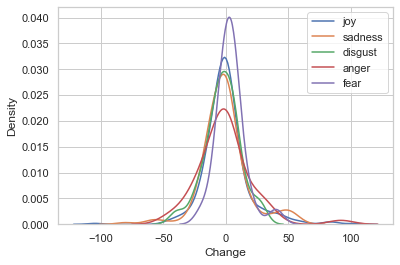

/Users/phillipholscher/opt/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



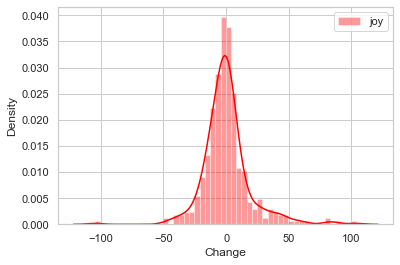

/Users/phillipholscher/opt/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



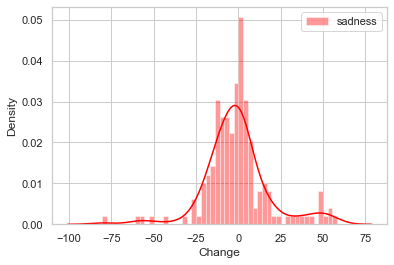

/Users/phillipholscher/opt/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



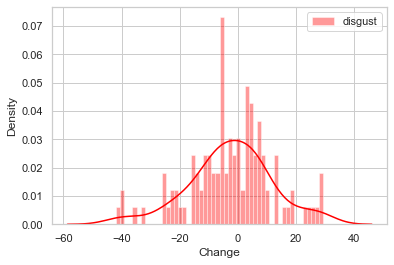

/Users/phillipholscher/opt/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



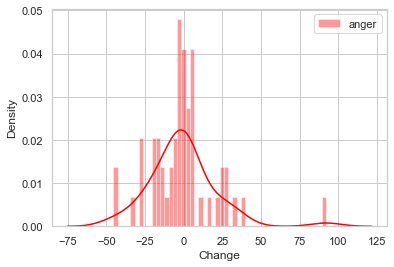

/Users/phillipholscher/opt/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



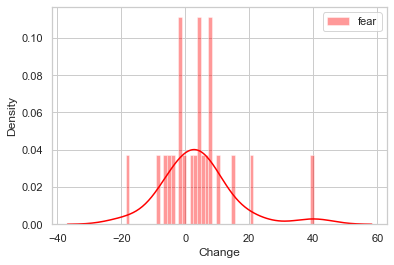

anger : (0.45, 0.55)
disgust : (0.43, 0.57)
fear : (0.61, 0.39)
joy : (0.45, 0.54)
sadness : (0.46, 0.54)


In [728]:
financial_analysis(twitter_d, S_and_P500, "S&P500")

# Dow Jones

In [729]:
DowJones = pd.read_csv("DowJones.csv")

Financial data analyis: DowJones


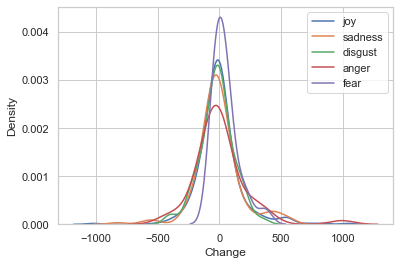

/Users/phillipholscher/opt/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



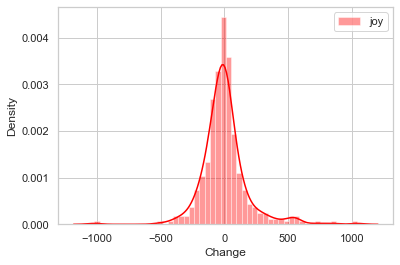

/Users/phillipholscher/opt/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



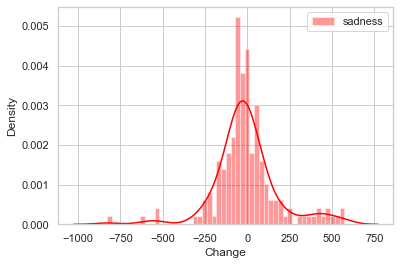

/Users/phillipholscher/opt/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



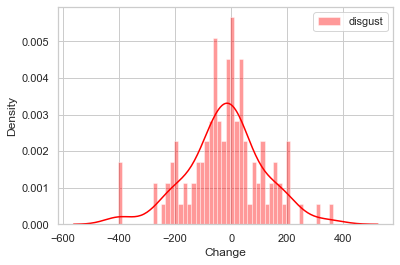

/Users/phillipholscher/opt/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



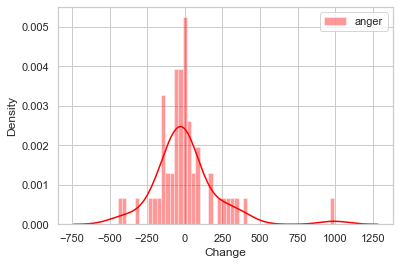

/Users/phillipholscher/opt/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



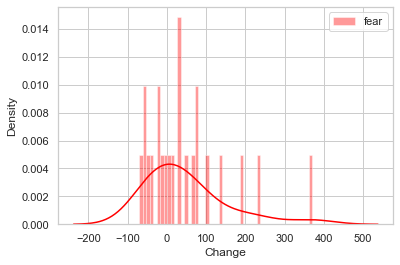

anger : (0.43, 0.57)
disgust : (0.43, 0.57)
fear : (0.61, 0.39)
joy : (0.45, 0.55)
sadness : (0.42, 0.58)


In [730]:
financial_analysis(twitter_d, DowJones, "DowJones")

# NASDAQ

In [732]:
NASDAQ = pd.read_csv("NASDAQ.csv")

Financial data analyis: NASDAQ


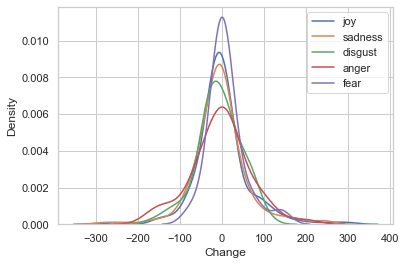

/Users/phillipholscher/opt/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



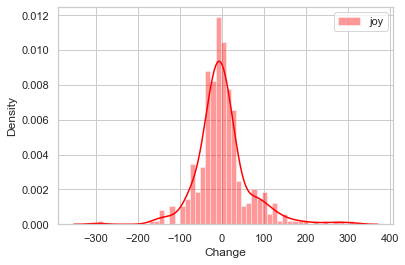

/Users/phillipholscher/opt/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



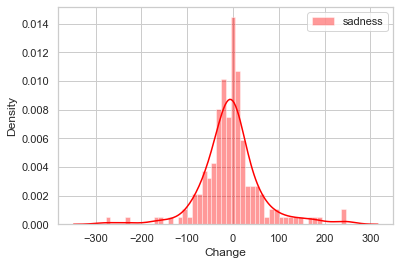

/Users/phillipholscher/opt/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



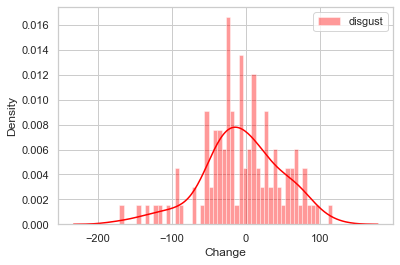

/Users/phillipholscher/opt/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



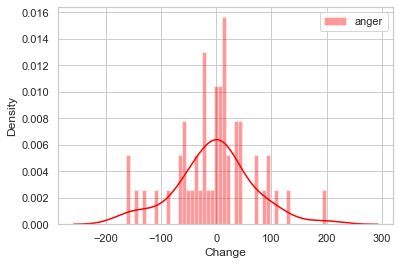

/Users/phillipholscher/opt/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



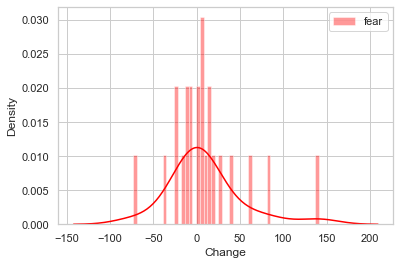

anger : (0.53, 0.47)
disgust : (0.43, 0.57)
fear : (0.57, 0.39)
joy : (0.44, 0.56)
sadness : (0.44, 0.56)


In [733]:
financial_analysis(twitter_d, NASDAQ, "NASDAQ")

# DAX

In [660]:
finance_d = pd.read_csv("DAX.csv")

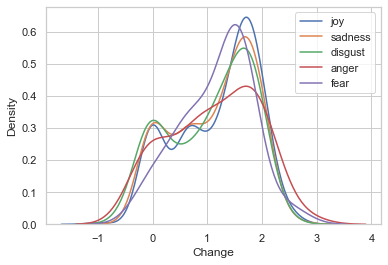

/Users/phillipholscher/opt/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



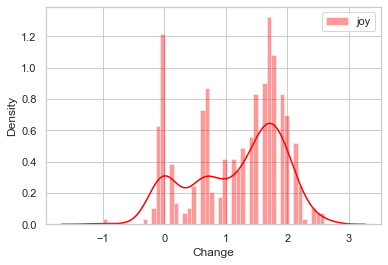

/Users/phillipholscher/opt/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



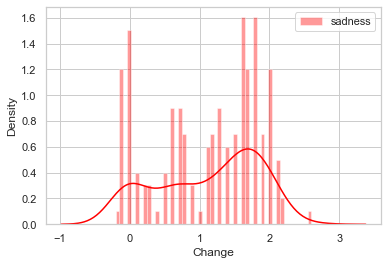

/Users/phillipholscher/opt/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



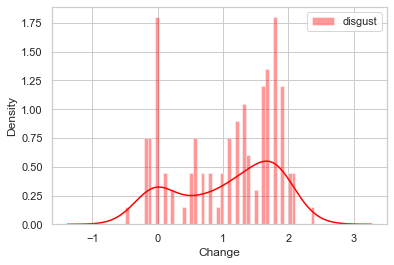

/Users/phillipholscher/opt/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



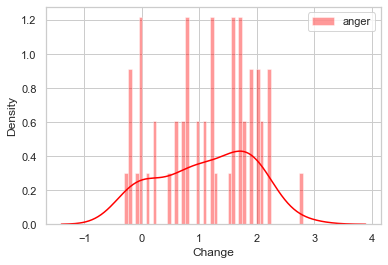

/Users/phillipholscher/opt/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



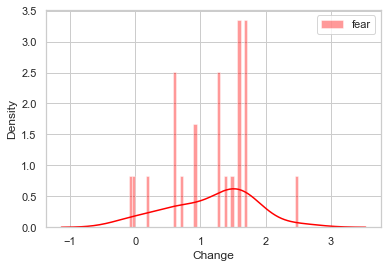

anger : (0.83, 0.09)
disgust : (0.8, 0.1)
fear : (0.91, 0.04)
joy : (0.85, 0.06)
sadness : (0.84, 0.07)


In [661]:
financial_analysis(twitter_d, finance_d)

In [669]:
finance_d["Change"] = finance_d["Open"] - finance_d["Adj Close"]
fig = px.scatter(finance_d, x = "Date", y = "Open")
fig.show()

# SSEComposite

In [734]:
SSEComposite = pd.read_csv("SSEComposite.csv")

Financial data analyis: SSEComposite


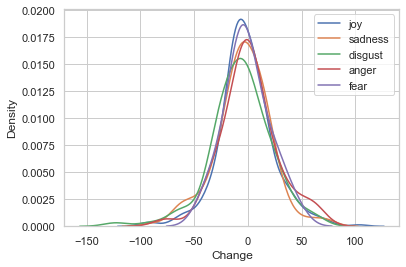

/Users/phillipholscher/opt/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



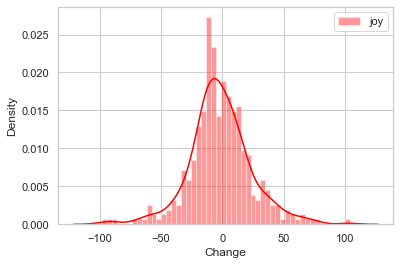

/Users/phillipholscher/opt/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



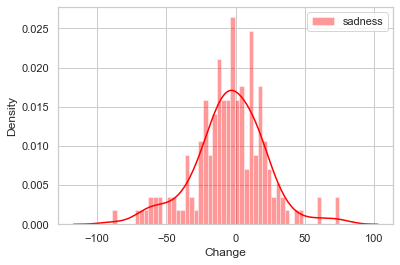

/Users/phillipholscher/opt/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



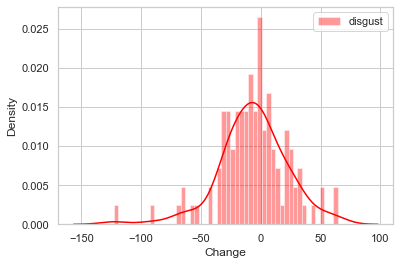

/Users/phillipholscher/opt/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



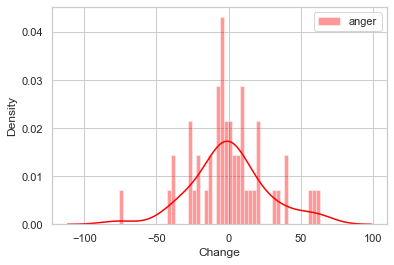

/Users/phillipholscher/opt/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



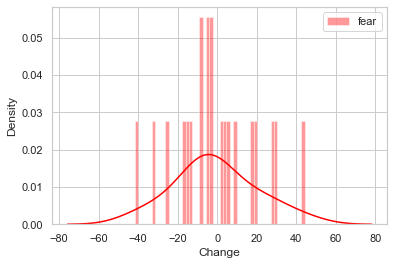

anger : (0.46, 0.54)
disgust : (0.37, 0.62)
fear : (0.43, 0.57)
joy : (0.45, 0.55)
sadness : (0.43, 0.57)


In [735]:
financial_analysis(twitter_d, SSEComposite, "SSEComposite")

# HANGSENGINDEX

In [737]:
HANGSENGINDEX = pd.read_csv("HANGSENGINDEX.csv")

Financial data analyis: HANGSENGINDEX


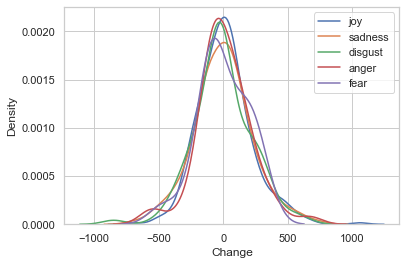

/Users/phillipholscher/opt/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



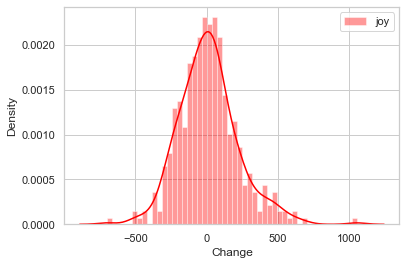

/Users/phillipholscher/opt/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



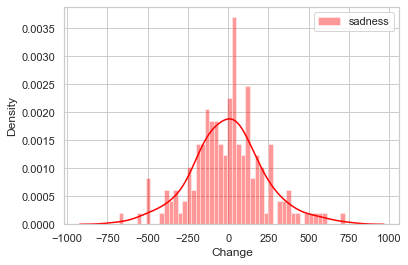

/Users/phillipholscher/opt/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



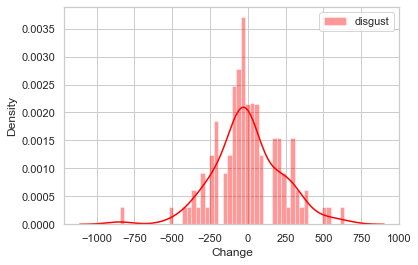

/Users/phillipholscher/opt/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



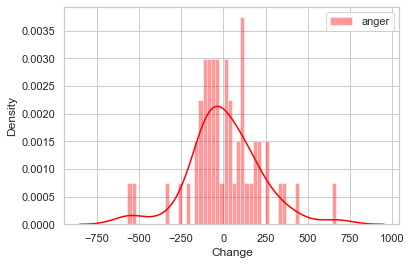

/Users/phillipholscher/opt/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



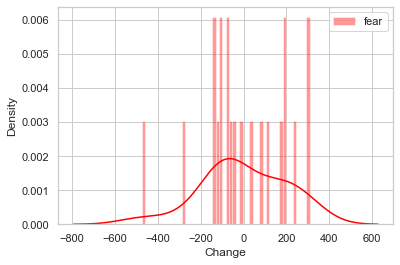

anger : (0.5, 0.5)
disgust : (0.43, 0.56)
fear : (0.43, 0.57)
joy : (0.5, 0.49)
sadness : (0.52, 0.48)


In [738]:
financial_analysis(twitter_d, HANGSENGINDEX, "HANGSENGINDEX")

# Read data

## Finance

In [634]:
# read finance data
data = pd.read_csv("S&P500.csv")

In [635]:
# for the analysis is "Date", "Open", "Close" what I need
data = data.loc[:,["Date","Open", "Adj Close"]]
#data["Change"] = data["Open"] - data["Adj Close"]
#data = data.loc[:,["Date","Change"]]
data.head()

,Date,Open,Adj Close
0,2017-01-03,19872.859375,19881.759766
1,2017-01-04,19890.939453,19942.160156
2,2017-01-05,19924.560547,19899.289063
3,2017-01-06,19906.960938,19963.800781
4,2017-01-09,19931.410156,19887.380859


## Twitter 

In [636]:
tweets_emotion = pd.read_csv("new_data_all.csv", sep = ",")
#emotion = emotion.loc[:,["date","emotion"]]
# remove all NaN emotion
## via watson no classification possible
tweets_emotion = tweets_emotion[tweets_emotion["emotion_probability"]< 1.0]

In [637]:
# update date column wiht full year
dates = []
for date in tweets_emotion["date"]:
    day = date.split(".")[0]
    month = date.split(".")[1]
    date2 = "20" + date.split(".")[2]
    full_date = day+ "." + month + "." + date2
    # convert string to date type
    dates.append(datetime.datetime.strptime(full_date, '%d.%m.%Y %H:%M'))
tweets_emotion["date"] = dates

# Create score - based on retweets, favoriets, emotion probability 

In [638]:
#--------------- emotion voteing - Start
# weighted method
tweets_emotion["score"] = round(tweets_emotion.emotion_probability * 
                                tweets_emotion.retweets/10000 * 
                                tweets_emotion.favorites/10000,2)
#--------------- emotion voteing - End

In [639]:
tweets_emotion

,index,username,date,retweets,favorites,text,emotion,emotion_probability,score
0,0,realDonaldTrump,2020-02-09 00:47:00,13459,72445,A great coach and a fantastic guy. His endorse...,joy,0.887483,8.65
1,1,realDonaldTrump,2020-02-08 22:08:00,47880,215503,Pete Rose played Major League Baseball for 24 ...,sadness,0.320811,33.10
2,2,realDonaldTrump,2020-02-08 20:48:00,9452,37402,Total and complete Endorsement for Debbie Lesk...,joy,0.755680,2.67
3,3,realDonaldTrump,2020-02-08 20:40:00,17545,62484,Governor Cuomo wanted to see me this weekend. ...,sadness,0.491409,5.39
4,4,realDonaldTrump,2020-02-08 20:01:00,27437,120598,We will not be touching your Social Security o...,anger,0.648076,21.44
...,...,...,...,...,...,...,...,...,...
9789,10245,realDonaldTrump,2017-01-07 16:02:00,24681,87739,Having a good relationship with Russia is a go...,sadness,0.522362,11.31
9790,10246,realDonaldTrump,2017-01-07 13:03:00,16601,73661,Only reason the hacking of the poorly defended...,sadness,0.567706,6.94
9791,10247,realDonaldTrump,2017-01-07 12:56:00,15401,60280,Intelligence stated very strongly there was ab...,sadness,0.490432,4.55
9792,10248,realDonaldTrump,2017-01-07 04:53:00,13961,59218,Gross negligence by the Democratic National Co...,disgust,0.746146,6.17


In [706]:
tweets_emotion["text"][1]

'Pete Rose played Major League Baseball for 24 seasons, from 1963-1986, and had more hits, 4,256, than any other player (by a wide margin). He gambled, but only on his own team winning, and paid a decades long price. GET PETE ROSE INTO THE BASEBALL HALL OF FAME. It’s Time!'

# Emotional vote

In [640]:
tweets_emotion_trans = df_time_transformation(tweets_emotion)

In [705]:
tweets_emotion_trans

,date,day,emotion,score
0,2020-02-09,Sunday,joy,8.65
1,2020-02-08,Saturday,sadness,33.10
2,2020-02-08,Saturday,joy,2.67
3,2020-02-08,Saturday,sadness,5.39
4,2020-02-08,Saturday,anger,21.44
...,...,...,...,...
9789,2017-01-07,Saturday,sadness,11.31
9790,2017-01-07,Saturday,sadness,6.94
9791,2017-01-07,Saturday,sadness,4.55
9792,2017-01-07,Saturday,disgust,6.17


In [703]:
test3 = tweets_emotion_trans.loc[:,["date", "emotion", "score"]][1:13]
test3

,date,emotion,score
1,2020-02-08,sadness,33.10
2,2020-02-08,joy,2.67
3,2020-02-08,sadness,5.39
4,2020-02-08,anger,21.44
5,2020-02-08,sadness,3.18
6,2020-02-08,sadness,3.65
7,2020-02-08,disgust,7.89
8,2020-02-08,disgust,10.76
9,2020-02-08,joy,6.30
10,2020-02-08,anger,8.70


In [704]:
test3 = test3.groupby("emotion").sum().reset_index()
test3.loc[:,["emotion", "score"]]

,emotion,score
0,anger,30.14
1,disgust,18.65
2,joy,58.54
3,sadness,45.32


### Example - Start

In [642]:
test = data_new[data_new["date"] == np.unique(data_new["date"])[2]]

test["score"] = round(test.emotion_probability * test.retweets/10000 * test.favorites/10000,2)
test

,date,day,retweets,favorites,text,emotion,emotion_probability,score
9773,2017-01-09,Monday,21346,110409,An old picture with Nancy and Ronald Reagan. p...,sadness,0.207513,4.89
9774,2017-01-09,Monday,19888,97009,Ford said last week that it will expand in Mic...,joy,0.492076,9.49
9775,2017-01-09,Monday,19825,89196,It's finally happening - Fiat Chrysler just an...,joy,0.742033,13.12
9776,2017-01-09,Monday,13474,60198,"groveling"" when he totally changed a 16 year o...",sadness,0.478602,3.88
9777,2017-01-09,Monday,17985,73630,Hillary flunky who lost big. For the 100th tim...,sadness,0.706549,9.36
9778,2017-01-09,Monday,31724,108093,"Meryl Streep, one of the most over-rated actre...",joy,0.384554,13.19
9779,2017-01-09,Monday,6155,32944,Rupert Murdoch is a great guy who likes me muc...,joy,0.913526,1.85
9780,2017-01-09,Monday,16187,67725,Dishonest media says Mexico won't be paying fo...,disgust,0.410850,4.50


In [643]:
test2 = test.groupby("emotion").sum().reset_index()
test2.loc[:,["emotion", "score"]]

,emotion,score
0,disgust,4.50
1,joy,37.65
2,sadness,18.13


### Example - End

In [644]:
# get emotion of the day
tweets_emotion_daily = get_daily_max_emotion(tweets_emotion_trans)

In [645]:
tweets_emotion_daily

,date,emotion
0,2017-01-07,sadness
1,2017-01-08,disgust
2,2017-01-09,joy
3,2017-01-10,joy
4,2017-01-11,sadness
...,...,...
1107,2020-02-05,disgust
1108,2020-02-06,joy
1109,2020-02-07,disgust
1110,2020-02-08,sadness


# Connection finance and emotion data

In [646]:
emotion_noweekend_change = index_change(tweets_emotion_daily, data)

In [647]:
emotion_noweekend_change

,date,emotion,Change
0,2017-01-09,joy,44
1,2017-01-10,joy,20.8
2,2017-01-11,sadness,-66.9
3,2017-01-12,sadness,35.2
4,2017-01-13,disgust,26.8
...,...,...,...
763,2020-02-03,joy,-80.2
764,2020-02-04,joy,-110.9
765,2020-02-05,disgust,-242.1
766,2020-02-06,joy,8.8


# Time to make visualizations

- Histogram for every emotion
- Histogram with distribution
- Distributions for every emotion
- Histogram every emotion different colored
- Box plot
- Scatter plot


[Helpful material](https://python-graph-gallery.com/)

[Plotly](https://plotly.com/python/)

In [648]:
df = emotion_noweekend_change

## Box plot

In [726]:
fig = px.box(df, x="emotion", y="Change", color="emotion")
#fig.savefig("boxplot_emotion_change.png")
#fig.write_image(file='boxplot_emotion_change.png', format='.png')
fig.show()

# Line plot - not used in the report

In [739]:
fig = px.line(df, x = "date", y = "Change", color = "emotion")
#fig.write_image(file='scatterplot_emotion_change.png', format='.png')
fig.show()

## Scatter plot

In [650]:
fig = px.scatter(df, x = "date", y = "Change", color = "emotion")
#fig.write_image(file='scatterplot_emotion_change.png', format='.png')
fig.show()

## Histogram

In [651]:
# Histogram all
fig = px.histogram(df, x = "emotion", color = "emotion")
fig.show()

## Distributions

In [533]:
df["date"] = pd.to_datetime(df["date"], format= "%Y-%m-%d")
df["Change"] = df["Change"].astype('float64')

/Users/phillipholscher/opt/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



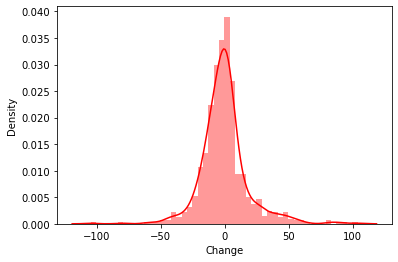

In [536]:
sns.distplot(df['Change'], kde = True, color ='red', bins = 50)
plt.show()

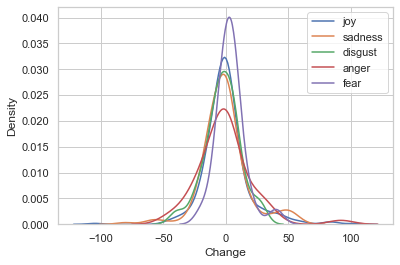

In [609]:
sns.set(style="whitegrid")
fig, ax = plt.subplots()

for emo in pd.unique(df["emotion"]):
    sns.kdeplot(df[df["emotion"] == emo]["Change"], ax=ax, label = emo)
plt.legend()
plt.savefig("distribution_change_density.png")
plt.show()


In [ ]:
from plotly.subplots import make_subplots
import plotly.graph_objects as go


fig = make_subplots(
    rows=3, cols=2,
    subplot_titles=("Plot 1", "Plot 2", "Plot 3", "Plot 4"))

fig.add_trace(go.Scatter(x=[1, 2, 3], y=[4, 5, 6]),
              row=1, col=1)

/Users/phillipholscher/opt/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



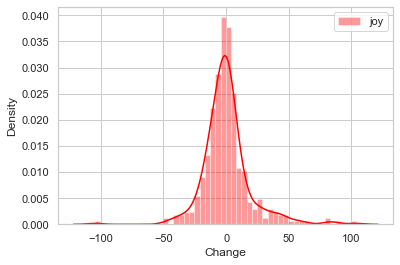

/Users/phillipholscher/opt/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



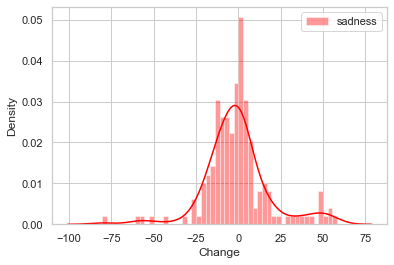

/Users/phillipholscher/opt/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



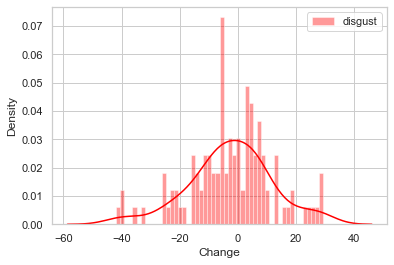

/Users/phillipholscher/opt/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



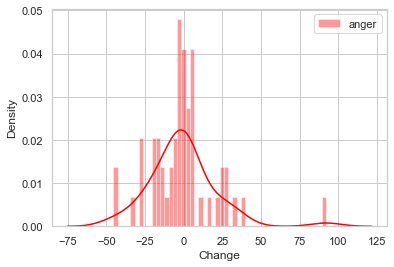

/Users/phillipholscher/opt/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



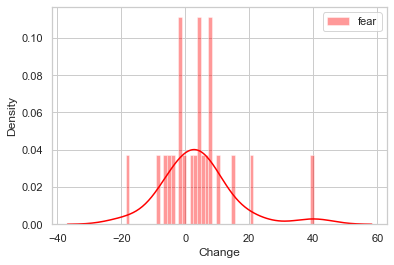

In [611]:
for emo in pd.unique(df["emotion"]):
    sns.distplot(df[df["emotion"] == emo]["Change"], kde = True, color ='red', bins = 50, label = emo)
    plt.legend()
    #plt.savefig("densityplot_change_density_" + emo + ".png")
    plt.show()

# Summary

The best visualizations

1. Box plot
2. Distribution
2. Histogram


- For each one visualization, so **all emotions in one plot**!

- Use **Plotly** for all visualizations!

- The **test data** is **to small** to make meaningfull visualizations!



In [586]:
def percentage_positive_negative(df, emotion):
    df_new = df[df["emotion"] == emotion]
    pos = round(len(df_new[df_new["Change"] > 0])/df_new.shape[0],2)
    neg = round(len(df_new[df_new["Change"] < 0])/df_new.shape[0],2)
    return(pos,neg)

In [589]:
emotions = np.unique(df["emotion"])
for emo in emotions:
    print(emo, ":", percentage_positive_negative(df, emo))

anger : (0.45, 0.55)
disgust : (0.43, 0.57)
fear : (0.61, 0.39)
joy : (0.45, 0.54)
sadness : (0.46, 0.54)
